# SITCOM-1120: Brake analysis

## Test Log: e-stop - rolex
 * 22-11-2023
 0.  Fisrt log TMA:  2023-11-22T19:56:33.622523   /// bquint@love01.cp.lsst.org  /
 1.  by 2023-11-23T00:51:28 / running the TMA Az/El breaks tests( E-stop ) /// ashugart@love01.cp.lsst.org 
 2.  by 2023-11-23T02:32:17.254532 /    bquint@love01.cp.lsst.org 
   * We ran another TMA Brake Test earlier today. Taking note now. 2023-11-23 00:38 UTC - 2023-11-23 00:42 UTC
   * TMA Brake tests in Azimuth - Going from 151º to 0º
   * We stopped around 102.5º, and we overshot until 89.67º
 3. 2023-11-23T03:08:50.50 /   bquint@love01.cp.lsst.org 
   * - 2023-11-23 01:02 UTC - 2023-11-23 01:05 UTC
   * - TMA Brake tests in Elevation - Going up from 20º to 80º.
   * - We stopped around 40º, and we overshooted until 45º.
 4.  2023-11-23 01:35 UTC - 2023-11-23 01:40 UTC / by bquint@love01.cp.lsst.org 2023-11-23T03:10:09
   * - TMA Brake tests in Elevation - Going down from 80º to 20º.
   * - We stopped around 57.8º, and we overshooted until 53.8º.
    
---

 * BLOCK-142 : https://jira.lsstcorp.org/browse/BLOCK-142


## Imports

In [1]:
import sys, time, os, asyncio, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from scipy.interpolate import UnivariateSpline


In [ ]:
client = EfdClient("usdf_efd")

In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Functions

### plot Azimuht(az, azXs, azVs, event1 = None event2=None)

In [2]:
def plot_az(az, azXs, azVs, event_1=None, event_2=None):
    plt.figure(figsize=(16, 15))
    plt.suptitle("lsst.sal.MTMount.azimuth", fontsize=18, fontweight="bold")

    ###########
    # Position
    plt.subplot(4, 1, 1)
    plt.plot(
        az.index,
        az["actualPosition"],
        label="Position",
    )
    plt.plot(
        az.index,
        az["demandPosition"],
        label="demandPosition",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Position", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 and event_2 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_datetime_2 = event_2.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    # Velocity
    plt.subplot(4, 1, 2)
    plt.plot(
        az["actualVelocity"],
        label="Velocity",
    )
    plt.plot(
        az["demandVelocity"],
        label="demandVelocity",
    )

    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 and event_2 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_datetime_2 = event_2.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    # Interpolation
    plt.subplot(4, 1, 3)
    plt.plot(
        azXs,
        azVs,
        label="Velocity",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    ###########
    plt.subplot(4, 1, 4)
    plt.plot(
        azXs,
        azAccSpline(azXs),
        label="Interpolated Acceleration ",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Acceleration", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # disign
    plt.tight_layout()
    plt.show()
    return

### format_time(t_start, t_end)

In [9]:
def format_time(t_start, t_end):
    """
    input --> output
    t_start, t_end **-->** start, end
    """
    start = Time(t_start, scale="utc", format="isot")
    end = Time(t_end, scale="utc", format="isot")
    return (start, end)

### call_az_data_range

In [4]:
def call_az_data_range(start, end):
    df_az = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=[
            "actualPosition",
            "actualVelocity",
            "demandPosition",
            "demandVelocity",
            "timestamp",
        ],
        begin=start,
        end=end,
    )
    return df_az

### call_el_data_range

In [5]:
def call_el_data_range(start, end):
    df_el = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=[
            "actualPosition",
            "actualVelocity",
            "demandPosition",
            "demandVelocity",
            "timestamp",
        ],
        begin=start,
        end=end,
    )
    return df_el

### acc_spline(df_test)

In [6]:
def acc_spline(df_test):
    elXs = df_test["timestamp"].values - df_test["timestamp"].values[0]
    elVs = df_test["actualVelocity"].values
    elVelSpline = UnivariateSpline(elXs, elVs, s=0)
    elAccSpline = elVelSpline.derivative(n=1)
    return (elAccSpline, elXs, elVs)

### miniformat(result)


In [11]:
def miniformat(df):
    """
    Formatting date
    """
    # Reiniciar el índice
    df.reset_index(inplace=True)
    # Asignar un nombre al índice
    df.index.name = "Axis"
    df = df.rename(columns={"index": "time"})
    print(df)
    df = str(df["time"][0])
    event = datetime.strptime(df, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
        "%Y-%m-%dT%H:%M:%S.%f"
    )
    print()
    print("Event happened at: ", event)
    event = Time(event, scale="utc", format="isot")
    return event

### get_event(start, end)

In [8]:
def get_event(start, end):
    """
    Fetch an event from a Axis stopped in a defined range of time.
    This need the find_state() function.

    Parameters:
     start, end : range of time to search.
    """
    df_az_state = getEfdData(
        client,
        "lsst.sal.MTMount.logevent_azimuthMotionState",
        columns=[
            "state",
            "timestamp",
        ],
        begin=start,
        end=end,
    )

    df_el_state = getEfdData(
        client,
        "lsst.sal.MTMount.logevent_elevationMotionState",
        columns=[
            "state",
            "timestamp",
        ],
        begin=start,
        end=end,
    )

    df_move = getEfdData(
        client,
        # "lsst.sal.MTMount.logevent_azimuthInPosition",
        "lsst.sal.MTMount.logevent_azimuthSystemState",
        columns=[
            "motionControllerState0",
            "motionControllerState5",
            "motionControllerState10",
        ],
        begin=start,
        end=end,
    )

    print()
    print("MTMount_logevent_azimuthSystemState (op-1): ")
    print(df_move)
    print()
    print("MTMount.logevent_azimuthMotionState (op-2): ")
    print(df_az_state)
    print()
    print("MTMount.logevent_elevationMotionState (op-3): ")
    print(df_el_state)
    print()

    # interactive_input():
    """
    Prompt the user for interactive input and execute an action based on the selected option.
    """
    # Prompt the user for input
    user_input = input("Please enter your option: ")

    # Use the user input in the notebook
    print(f"You have entered: {user_input}")

    # Continue with code based on the input
    if user_input == "1":
        print("You selected azimuthSystemState")
        event = miniformat(df_move)
    elif user_input == "2":
        print("You selected azimuthMotionState")
        event = miniformat(df_az_state)
    else:
        print("You selected elevationMotionState")
        event = miniformat(df_el_state)

    print()

    return event

### plot Elevation  / (el, elXs, elVs, event=None):

In [9]:
def plot_el(el, elXs, elVs, event_1=None, event_2=None):
    plt.figure(figsize=(16, 15))
    plt.suptitle("lsst.sal.MTMount.elevation", fontsize=18, fontweight="bold")

    ###########
    # Position
    plt.subplot(4, 1, 1)
    plt.plot(
        el.index,
        el["actualPosition"],
        label="Position",
    )
    plt.plot(
        el.index,
        el["demandPosition"],
        label="demandPosition",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Position", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 and event_2 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_datetime_2 = event_2.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    # Velocity
    plt.subplot(4, 1, 2)
    plt.plot(
        el["actualVelocity"],
        label="Velocity",
    )
    plt.plot(
        el["demandVelocity"],
        label="demandVelocity",
    )

    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 and event_2 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_datetime_2 = event_2.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    ############################################
    # Interpolation
    plt.subplot(4, 1, 3)
    plt.plot(
        elXs,
        elVs,
        label="Velocity",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)
    ############
    plt.subplot(4, 1, 4)
    plt.plot(
        elXs,
        elAccSpline(elXs),
        label="Interpolated Acceleration ",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Acceleration", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)
    ############################################

    # disign
    plt.tight_layout()
    plt.show()
    return

### delta_time

In [10]:
#################################
def delta_time(timestamp1, timestamp2):
    # Convert to datetime objects
    dt1 = datetime.fromisoformat(timestamp1)
    dt2 = datetime.fromisoformat(timestamp2)

    # Calculate time difference
    diff = dt2 - dt1
    print(f"Time difference: {diff}")
    return diff

    #################################

### get_format_h(df)

In [11]:
def get_format_h(df):
    try:
        date_stop = str(df["time"][0])
        h_event = datetime.strptime(date_stop, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
            "%H:%M:%S.%f"
        )[:-3]

        # Convertir el evento a objeto datetime
        h_event = pd.to_datetime(h_event)

    except:
        pos_time = str(df)
        h_event = datetime.strptime(pos_time, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
            "%Y-%m-%dT%H:%M:%S.%f"
        )

    return h_event

### find_first_non_zero_from_end

In [12]:
def find_first_non_zero_from_end(df, col_name, threshold=0.01):
    """
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    col_name (str): The name of the column to check.
    threshold (float): The tolerance threshold for considering a value as zero.

    Returns:
    tuple: A tuple containing:
        - The row where the value stops being zero.
        - The name of the column.
        - The value in the column at that row.
    """
    # Reverse the DataFrame to search from the end
    reversed_df = df.iloc[::-1]

    # Iterate over the reversed DataFrame
    for i in range(len(reversed_df)):
        if abs(reversed_df[col_name].iloc[i]) > threshold:
            # Get the row index in the original DataFrame
            original_index = reversed_df.index[i]
            # Get the row, column name, and value
            row = df.loc[original_index]
            value = df.at[original_index, col_name]
            return (row, col_name, value)

    # If no non-zero value is found, return None
    return None

### Period TimeStamp:
##################################################

start, end = format_time("2023-11-22T20:05:00", "2023-11-23T06:07:00")

##################################################

test: lsst.sal.mtmount.command_stop

## Cases

### Same data than case 2 / Case 1: 
 1.  by 2023-11-23T00:51:28 / running the TMA Az/El breaks tests( E-stop ) /// ashugart@love01.cp.lsst.org 


In [13]:
##################################################
time_start = "2023-11-23T00:38:05"
time_ends = "2023-11-23T00:40:15"
##################################################

### Case 2:
 2.  by 2023-11-23T02:32:17.254532 /    bquint@love01.cp.lsst.org 
   * We ran another TMA Brake Test earlier today. Taking note now. 2023-11-23 00:38 UTC - 2023-11-23 00:42 UTC
   * TMA Brake tests in Azimuth - Going from 151º to 0º
   * We stopped around 102.5º, and we overshot until 89.67º


In [14]:
##################################################
time_start = "2023-11-23T00:40:20"
time_ends = "2023-11-23T00:42:10"
##################################################
start, end = format_time(time_start, time_ends)
df_az = call_az_data_range(start, end)
event1 = get_event(start, end)
##################################################


MTMount_logevent_azimuthSystemState (op-1): 
                                  motionControllerState0  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState5  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState10  
2023-11-23 00:40:36.120481+00:00                        2  

MTMount.logevent_azimuthMotionState (op-2): 
                                  state timestamp
2023-11-23 00:40:28.305729+00:00      2      None

MTMount.logevent_elevationMotionState (op-3): 
                                  state timestamp
2023-11-23 00:40:28.313140+00:00      2      None
2023-11-23 00:40:28.975216+00:00      1      None



Please enter your option:  2


You have entered: 2
You selected azimuthMotionState
                                 time  state timestamp
Axis                                                  
0    2023-11-23 00:40:28.305729+00:00      2      None

Event happened at:  2023-11-23T00:40:28.305729



In [15]:
event2 = get_event(start, end)


MTMount_logevent_azimuthSystemState (op-1): 
                                  motionControllerState0  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState5  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState10  
2023-11-23 00:40:36.120481+00:00                        2  

MTMount.logevent_azimuthMotionState (op-2): 
                                  state timestamp
2023-11-23 00:40:28.305729+00:00      2      None

MTMount.logevent_elevationMotionState (op-3): 
                                  state timestamp
2023-11-23 00:40:28.313140+00:00      2      None
2023-11-23 00:40:28.975216+00:00      1      None



Please enter your option:  1


You have entered: 1
You selected azimuthSystemState
                                 time  motionControllerState0  \
Axis                                                            
0    2023-11-23 00:40:36.120481+00:00                       2   

      motionControllerState5  motionControllerState10  
Axis                                                   
0                          2                        2  

Event happened at:  2023-11-23T00:40:36.120481



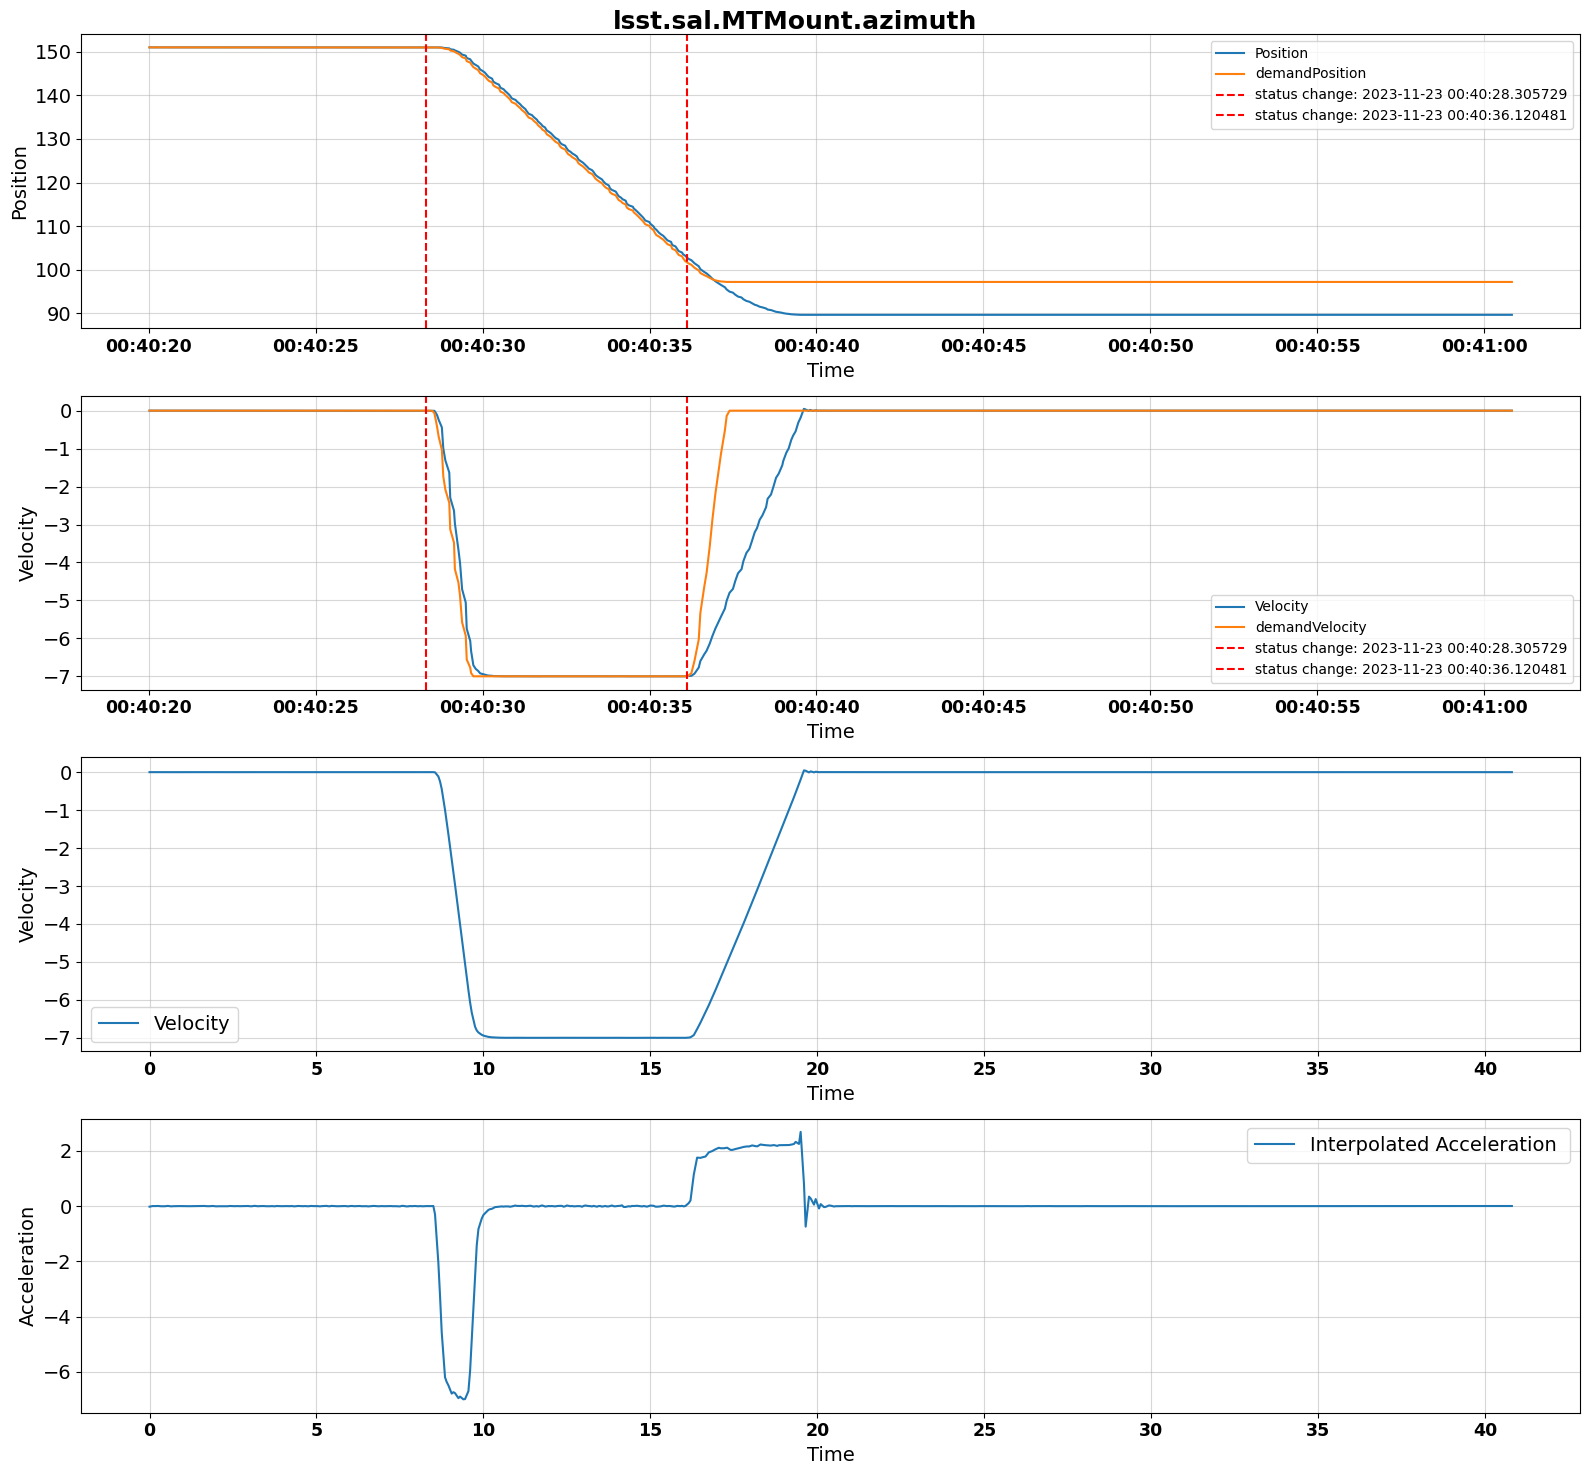

In [16]:
##################################################
azAccSpline, azXs, azVs = acc_spline(df_az)
plot_az(df_az, azXs, azVs, event1, event2)
##################################################

### ZOOM

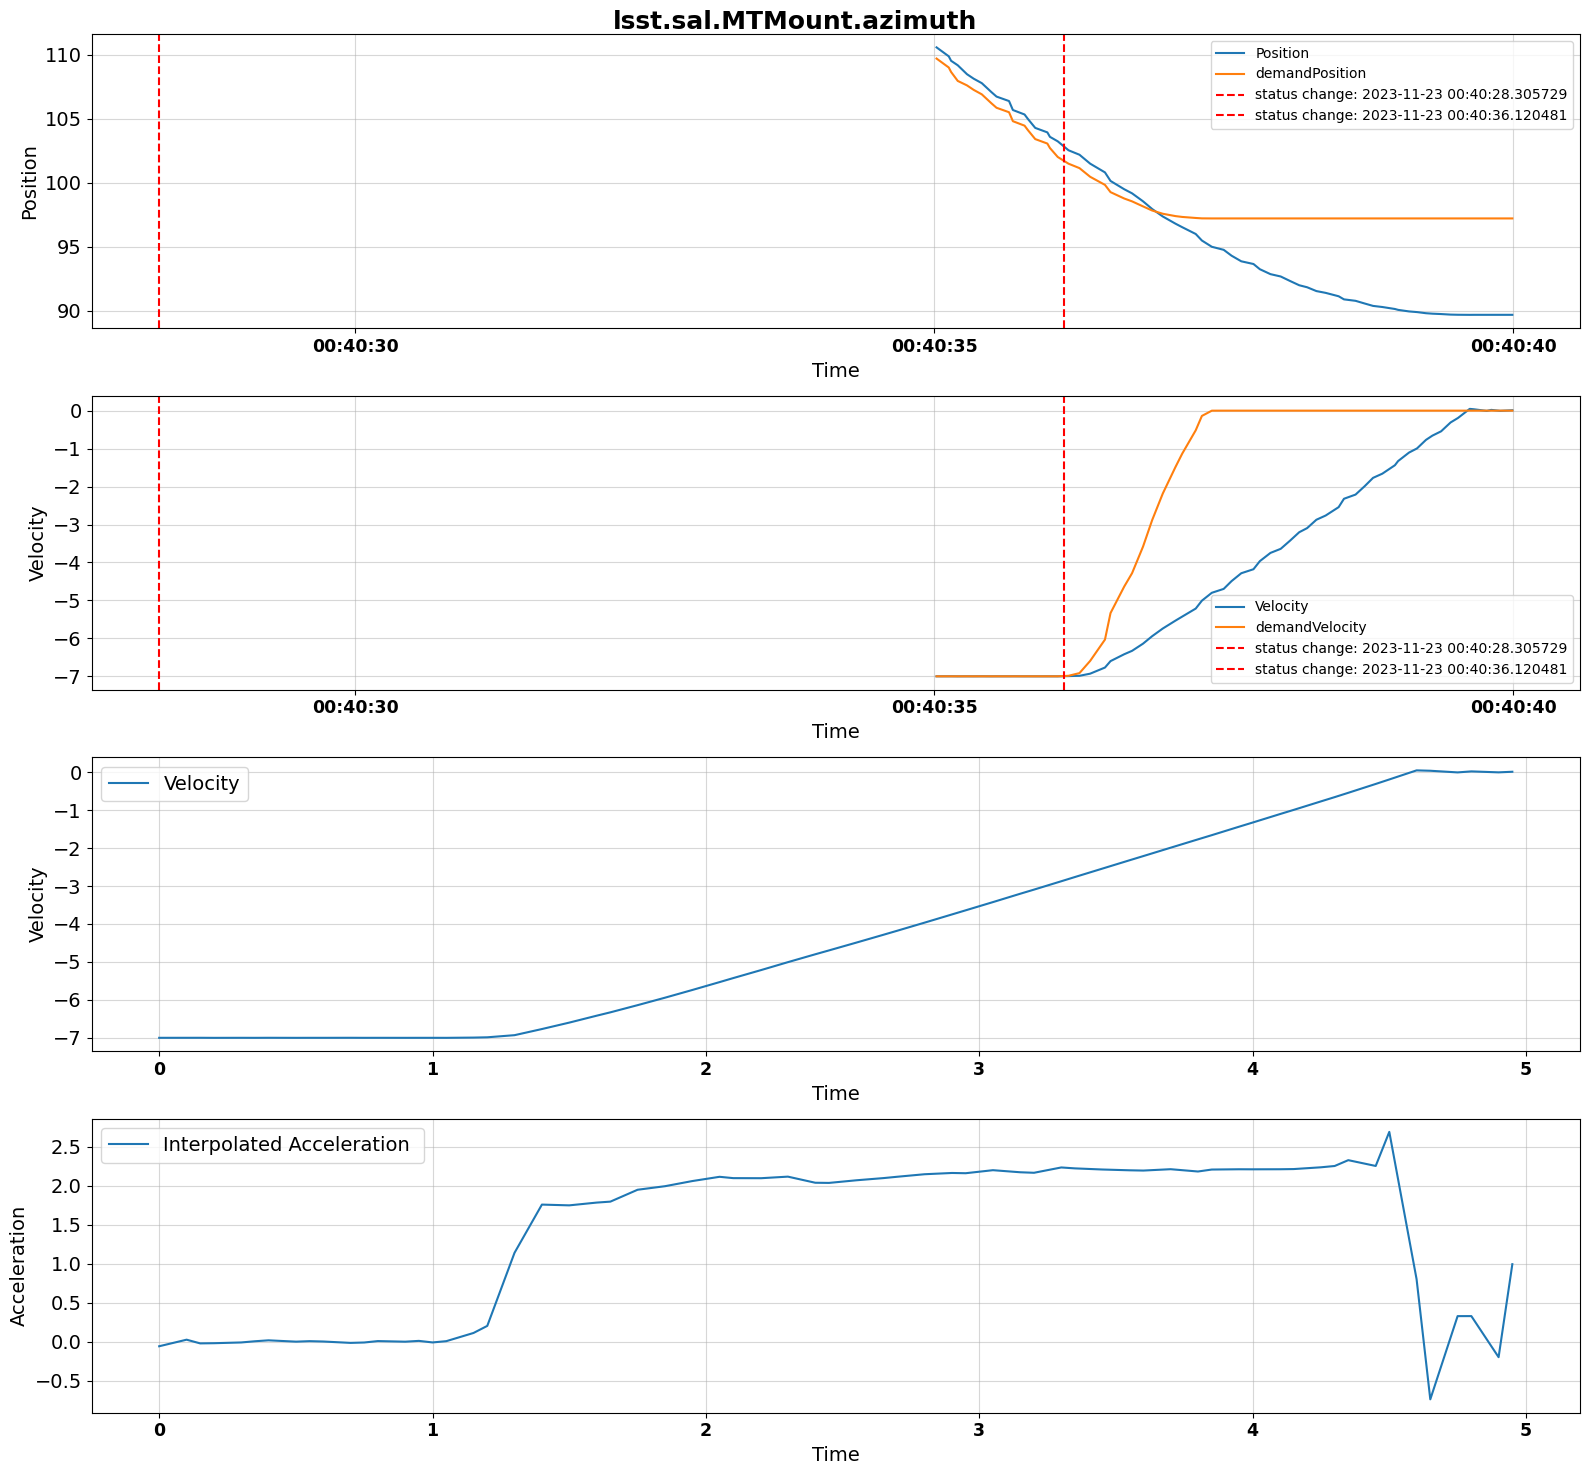

In [17]:
##################################################
time_start = "2023-11-23T00:40:35"
time_ends = "2023-11-23T00:40:40"
##################################################
start, end = format_time(time_start, time_ends)
df_az = call_az_data_range(start, end)
##################################################
azAccSpline, azXs, azVs = acc_spline(df_az)
plot_az(df_az, azXs, azVs, event1, event2)

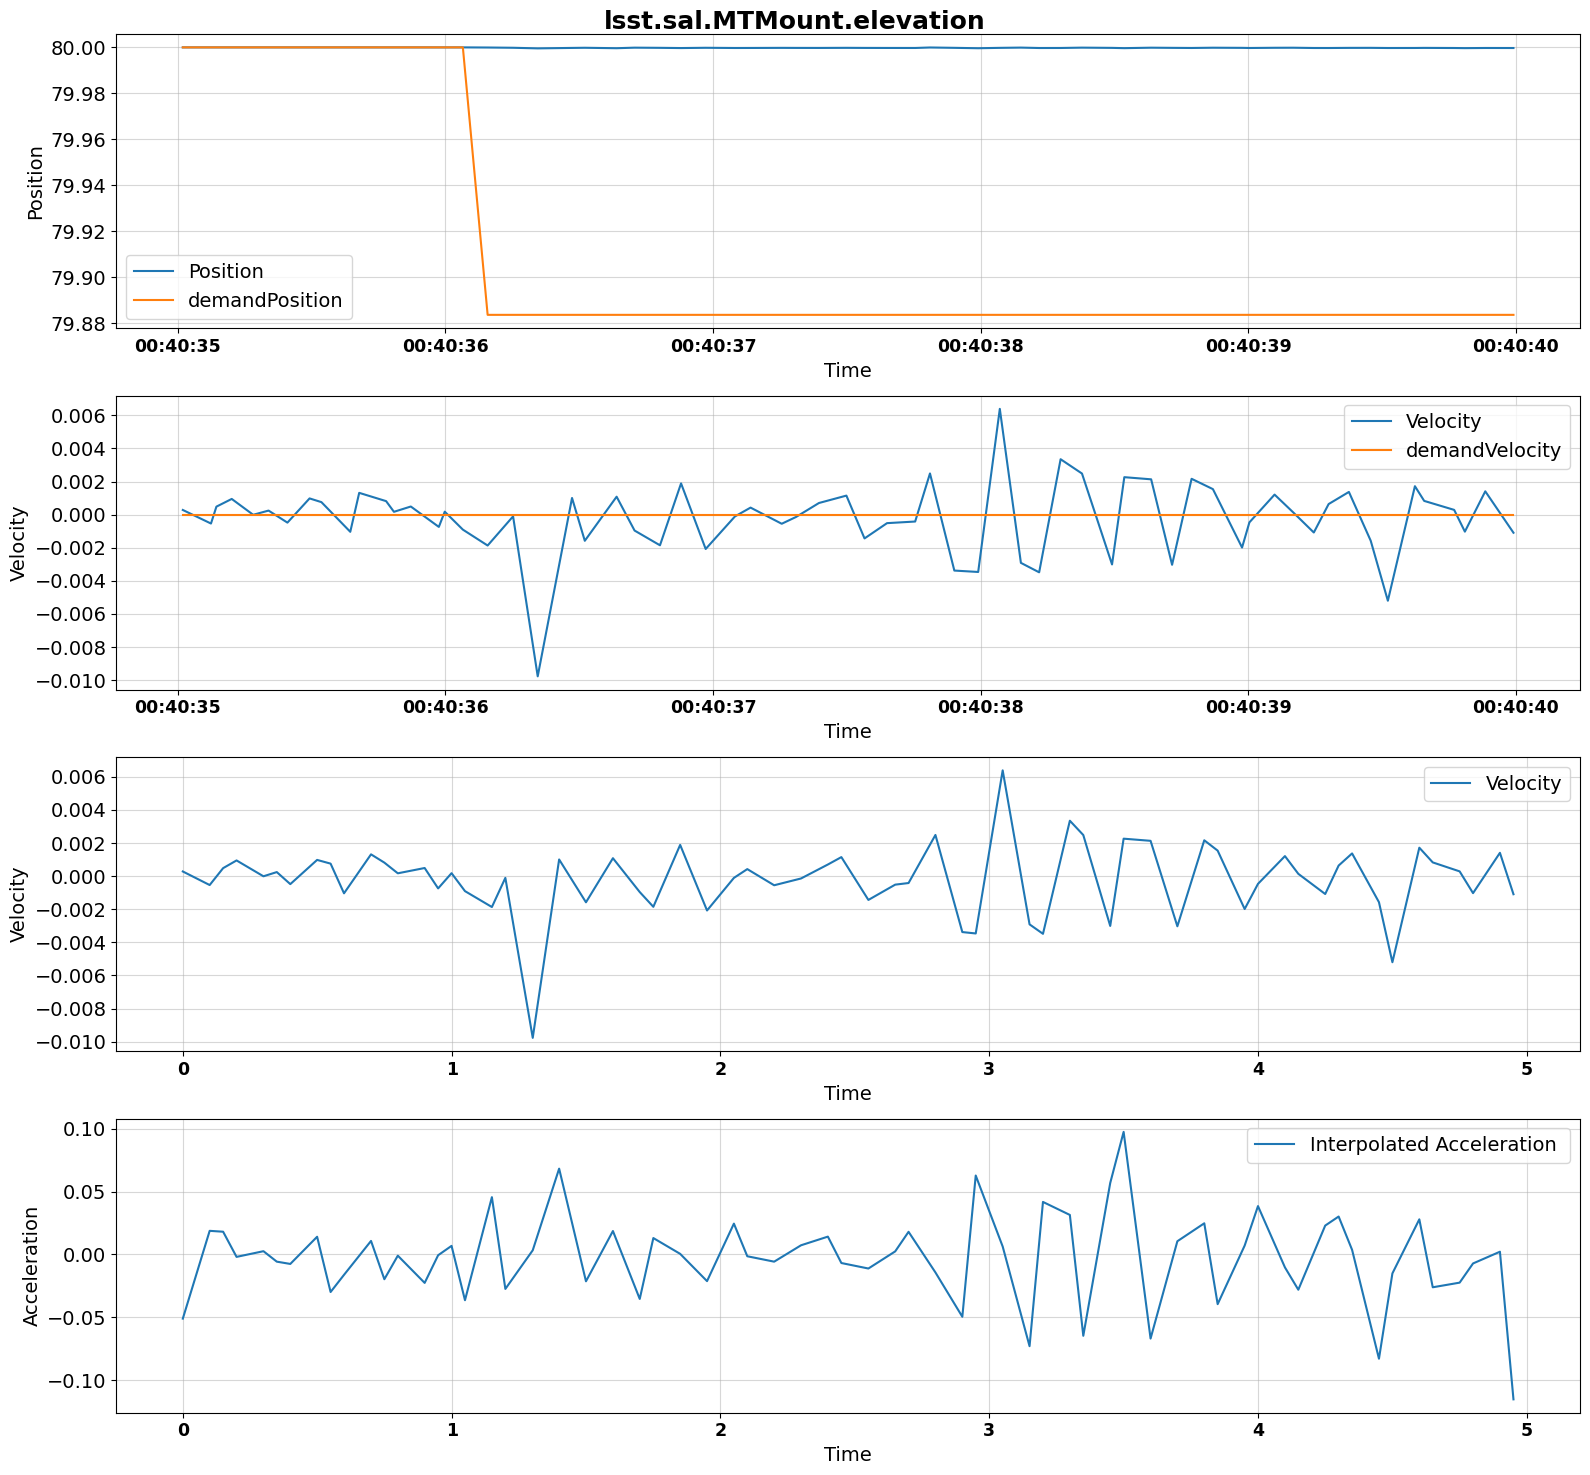

In [18]:
##################################################
df_el = call_el_data_range(start, end)
elAccSpline, elXs, elVs = acc_spline(df_el)
plot_el(df_el, elXs, elVs)
##################################################

### Note.
Input: e-stop triggered  p2p ///   

    * 2023-11-23 00:40:36.120481+00:00   ///  * Name: 2023-11-23 00:40:39.990298+00:00

### When Telescope stop moving?

In [19]:
difference = df_az["demandPosition"] - df_az["actualPosition"]

In [20]:
df_az["difference"] = difference

In [21]:
df_az["difference"].tail(10)

2023-11-23 00:40:39.299974+00:00    7.451426
2023-11-23 00:40:39.375400+00:00    7.481438
2023-11-23 00:40:39.457129+00:00    7.524223
2023-11-23 00:40:39.520990+00:00    7.536769
2023-11-23 00:40:39.622258+00:00    7.543328
2023-11-23 00:40:39.656782+00:00    7.540980
2023-11-23 00:40:39.768999+00:00    7.541637
2023-11-23 00:40:39.808768+00:00    7.541117
2023-11-23 00:40:39.885200+00:00    7.541437
2023-11-23 00:40:39.990298+00:00    7.541148
Name: difference, dtype: float64

####  Distance that the telescope moves once the systems recieve the siganl. Ref: Position figure.
#### This is not the e-stop time triggeret .... 

### D = 7.54 [deg]

### Distance determination

#### a). Actual Position - Last position of ... (data from the zoom)

In [22]:
# Last azimuth position:
last_aPos = df_az["actualPosition"].iloc[-1]  # --> 89.672343
print("Last azimuth position: ", "%.3f" % last_aPos, " [deg]")

Last azimuth position:  89.672  [deg]


#### b) from velocity figure. 

When velocity start changing the position can be determined

value_to_find = "2023-11-23 00:40:36.120481+00:00"

* value when velocity start changing.

In [23]:
df_az.index

DatetimeIndex(['2023-11-23 00:40:35.018296+00:00',
               '2023-11-23 00:40:35.123800+00:00',
               '2023-11-23 00:40:35.143883+00:00',
               '2023-11-23 00:40:35.201331+00:00',
               '2023-11-23 00:40:35.281225+00:00',
               '2023-11-23 00:40:35.338932+00:00',
               '2023-11-23 00:40:35.409118+00:00',
               '2023-11-23 00:40:35.492114+00:00',
               '2023-11-23 00:40:35.536163+00:00',
               '2023-11-23 00:40:35.644250+00:00',
               '2023-11-23 00:40:35.677436+00:00',
               '2023-11-23 00:40:35.778118+00:00',
               '2023-11-23 00:40:35.807177+00:00',
               '2023-11-23 00:40:35.870475+00:00',
               '2023-11-23 00:40:35.975136+00:00',
               '2023-11-23 00:40:35.997380+00:00',
               '2023-11-23 00:40:36.064734+00:00',
               '2023-11-23 00:40:36.157645+00:00',
               '2023-11-23 00:40:36.252471+00:00',
               '2023-11-23 00:4

In [24]:
# El numero mas cercano al anterior
#'2023-11-23 00:40:36.157645+00:00'

In [25]:
df_az["timestamp"] = df_az.index  # Establecer la columna 'timestamp' como índice

# Convertir timestamps a strings
df_az["timestamp"] = df_az["timestamp"].astype(str)

# Valor a buscar
search_value = "2023-11-23 00:40:36.157645+00:00"

# Buscar en la columna 'timestamp' como string
matching_rows = df_az[df_az["timestamp"] == search_value]

if not matching_rows.empty:
    print(f"Rows corresponding to the timestamp '{search_value}':")
    print(matching_rows)
    first_aPos = matching_rows["actualPosition"]
else:
    print(f"Timestamp '{search_value}' not found in the column.")

aPos = first_aPos - last_aPos
print()
print("aPos = first_azPos - last_azPos")
print(" > Difference on azimuth positions: ", aPos, " [deg]")

Rows corresponding to the timestamp '2023-11-23 00:40:36.157645+00:00':
                                  actualPosition  actualVelocity  \
2023-11-23 00:40:36.157645+00:00      102.546129       -6.993879   

                                  demandPosition  demandVelocity  \
2023-11-23 00:40:36.157645+00:00      101.496587        -6.98614   

                                                         timestamp  difference  
2023-11-23 00:40:36.157645+00:00  2023-11-23 00:40:36.157645+00:00   -1.049541  

aPos = first_azPos - last_azPos
 > Difference on azimuth positions:  2023-11-23 00:40:36.157645+00:00    12.873785
Name: actualPosition, dtype: float64  [deg]


### D = 12.874 [deg]

### Calculo : 

Input: e-stop triggered

    * 2023-11-23 00:40:36.120481+00:00 
    
Input: Point when velocity is diff from 0.0

    * Name: 2023-11-23 00:40:39.990298+00:00

In [26]:
#### First_non_zero_from_end /  function pending for verification !!
# Call the function to find the first non-zero row from the end
result = find_first_non_zero_from_end(df_az, "actualVelocity")
if result is not None:
    row, col_name, value = result
    print("Row where values stop being zero:")
    print(row)
    print(f"Column name: {col_name}")
    print(f"Value in the column: {value}")
else:
    print("All values are zero.")

Row where values stop being zero:
actualPosition                           89.672343
actualVelocity                             0.01041
demandPosition                           97.213491
demandVelocity                                -0.0
timestamp         2023-11-23 00:40:39.990298+00:00
difference                                7.541148
Name: 2023-11-23 00:40:39.990298+00:00, dtype: object
Column name: actualVelocity
Value in the column: 0.0104097924626416


### F(t) Delta Time

In [27]:
#################################
def delta_time(timestamp1, timestamp2):
    # Convert to datetime objects
    dt1 = datetime.fromisoformat(timestamp1)
    dt2 = datetime.fromisoformat(timestamp2)

    # Calculate time difference
    diff = dt2 - dt1
    print(f"Time difference: {diff}")
    return diff


#################################

In [28]:
# data from motionControllerState10
timestamp1 = "2023-11-23 00:40:36.120481+00:00"

# Data from "find_first_non_zero_from_end"
timestamp2 = "2023-11-23 00:40:39.990298+00:00"

delta_time(timestamp1, timestamp2)

Time difference: 0:00:03.869817


datetime.timedelta(seconds=3, microseconds=869817)

### Conclusion: Time difference: 0:00:03.869817

### Case 3:
 3. 2023-11-23T03:08:50.50 /   bquint@love01.cp.lsst.org 
   * - 2023-11-23 01:02 UTC - 2023-11-23 01:05 UTC
   * - TMA Brake tests in Elevation - Going up from 20º to 80º.
   * - We stopped around 40º, and we overshooted until 45º.


In [29]:
##################################################
time_start = "2023-11-23T01:03:50"
time_ends = "2023-11-23T01:04:15"
##################################################

### Case 4:
 4.  2023-11-23 01:35 UTC - 2023-11-23 01:40 UTC / by bquint@love01.cp.lsst.org 2023-11-23T03:10:09
   * - TMA Brake tests in Elevation - Going down from 80º to 20º.
   * - We stopped around 57.8º, and we overshooted until 53.8º.

In [30]:
time_start = "2023-11-23T01:43:00"
time_ends = "2023-11-23T02:00:00"